Informations
* Data collecting tool: **Tcpdump**  
* Features extraction tool: **Argus**

In [1]:
import os
import pandas as pd
import random
import numpy as np
import json
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

1. Preprocessing

In [2]:
folder = os.path.join("..", "0_dataset", "traffic")
filenames = ['label_traffic_mirai.csv', 'label_traffic_disk_wipe.csv', 'label_traffic_ransomware.csv',
                   'label_traffic_resource_hijacking.csv', 'label_traffic_end_point_dos.csv']

one_hot_col_list = ['Flgs', 'Proto', 'State']
fields_with_hex_value = ['Sport', 'Dport']
# removed_fields = ['Rank', 'StartTime', 'SrcAddr', 'DstAddr', 'LastTime', 'Tactic', 'Technique', 'SubTechnique']
removed_fields = ['Rank', 'SrcAddr', 'DstAddr', 'Tactic', 'Technique', 'SubTechnique']
replace_strings = dict()
remove_rows_with_str = dict()
technique_data_size = [0]

df = pd.DataFrame()
for tmp_filename in filenames:
    print("\n")
    print("-------------------------------------")
    print("file name:{0}".format(tmp_filename))
    print("-------------------------------------")
    filename = os.path.join(folder, tmp_filename)
    tmp_df = pd.read_csv(filename, low_memory=False)
    tmp_df = tmp_df.drop(tmp_df[tmp_df['Label'] == -1].index)

    # delete redundant data
    if tmp_filename == 'label_traffic_mirai.csv':
        drop_indexes = tmp_df[tmp_df['SubTechnique'] == 'Direct Network Flood'].index
        print('MIRAI Direct Network Flood data delete: {0}'.format(len(drop_indexes)))
        number_drop = len(drop_indexes) - 30000
        drop_indexes = random.sample(list(drop_indexes), number_drop)
        tmp_df = tmp_df.drop(drop_indexes)

    # simple analysis
    labels = tmp_df['Label'].unique()
    print('label uniques: {0}'.format(labels))
    for j in labels:
        class_data_size = len(tmp_df[tmp_df['Label'] == j])
        # print('number of class-{0}: {1}'.format(j, class_data_size))
        if j == 0:
            technique_data_size[0] += class_data_size
        else:
            technique_data_size.append(class_data_size)
    # print("feature numbers: {0}".format(len(column_names)))
    # print(tmp_df.dtypes)
    # print(tmp_df.isnull().any())
    df = df.append(tmp_df)

# delete useless features
for field in removed_fields:
    del df[field]

# one-hot-encoding
df = pd.get_dummies(df, columns=one_hot_col_list)

# string replacement
for old_value, new_value in replace_strings.items():
    df = df.replace(to_replace=old_value, value=new_value, regex=True)
for old_value, new_value in remove_rows_with_str.items():
    df = df.replace(to_replace=old_value, value=new_value)

# preprocess hex value, str -> int
for field in fields_with_hex_value:
    df[field] = df[field].fillna(-1)
    df[field] = df[field].apply(lambda x: x if type(x) is str else int(x))
    df[field] = df[field].apply(lambda x: int(x, 0) if type(x) is str and x[:2] == "0x" else x)
    # df[field] = df[field].apply(lambda x: int(str(x), 0))
    df[field] = df[field].apply(lambda x: int(float(str(x))))

# column name cleaning
column_names = df.columns.values
for i in range(len(column_names)):
    column_names[i] = column_names[i].strip()
df.columns = column_names

output_filename = os.path.join(folder, 'preprocess_label_traffic.csv')
df.to_csv(output_filename, encoding='utf-8', index=False)



-------------------------------------
file name:label_traffic_mirai.csv
-------------------------------------
MIRAI Direct Network Flood data delete: 2750680
label uniques: [0 1]


-------------------------------------
file name:label_traffic_disk_wipe.csv
-------------------------------------
label uniques: [0 1]


-------------------------------------
file name:label_traffic_ransomware.csv
-------------------------------------
label uniques: [0 1]


-------------------------------------
file name:label_traffic_resource_hijacking.csv
-------------------------------------
label uniques: [0 1]


-------------------------------------
file name:label_traffic_end_point_dos.csv
-------------------------------------
label uniques: [0 1]


2. Visualization (class number)

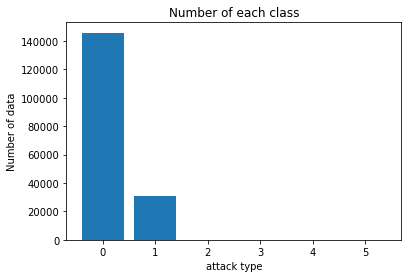

number of class-0: 145884
number of class-1: 31198
number of class-2: 34
number of class-3: 17
number of class-4: 17
number of class-5: 12


In [13]:
def bar_class_num(technique_data_size):
    labels = [i for i in range(len(technique_data_size))]
    class_num = np.arange(len(technique_data_size))
    plt.bar(class_num, technique_data_size)
    plt.xticks(class_num, labels)
    plt.xlabel("attack type")
    plt.ylabel("Number of data")
    plt.title("Number of each class")
    plt.show()

bar_class_num(technique_data_size)
for i in range(len(technique_data_size)):
    print('number of class-{0}: {1}'.format(i, technique_data_size[i]))

3. Data evaluation

In [ ]:
def loadDataset2RankFeature(folder, filename, hash_fields=['proto', 'service', 'state'], \
                            removed_fields=['id', 'attack_cat'], replace_strings=dict(),
                            remove_rows_with_str=[], label_field='label',
                            tactic_field='Tactic', technique_field='Technique', sub_technique_field='SubTechnique'):
    # load data, will be removed in deployment
    #hash_fields = ['proto', 'service', 'state']
    #removed_fields = ['id', 'attack_cat']
    
    df = loadDataset(folder, filename, hash_fields, removed_fields, replace_strings=replace_strings,
                     remove_rows_with_str=remove_rows_with_str)
    # using label field to calculate feature importance
    #del df[tactic_field]
    #del df[technique_field]
    #del df[sub_technique_field]

    X = df.loc[:, df.columns != label_field]
    y = df.loc[:, df.columns == label_field]
    features_train = X.columns.values
    X = X.values
    y = y.values

    return X, y, features_train

def rankFeatures(folder=r'Logs/test', filename='UNSW_NB15_training-set.csv', hash_fields=['proto', 'service', 'state'], 
            removed_fields = ['id', 'attack_cat'], replace_strings=dict(), remove_rows_with_str=[],
                 label_field='label', tactic_field='Tactic', technique_field='Technique',
                 sub_technique_field='SubTechnique', threshold=0.01, data_source=''):
    X, y, features_train = loadDataset2RankFeature(folder, filename, hash_fields, removed_fields,
                                                   replace_strings, remove_rows_with_str, label_field,
                                                   tactic_field, technique_field, sub_technique_field)

    models = {}
    # models = []
    #models.append(['Decision Tree Classifier', DecisionTreeClassifier()])
    #models.append(['Random Forest Classifier', RandomForestClassifier()])

    # linear models
    #models.append(['logistic', LogisticRegression()])
    # non-linear models
    models.append(['decision_tree', DecisionTreeClassifier()])
    models.append(['extra_tree', ExtraTreeClassifier()])
    #models.append(['naive_bayes', GaussianNB()])
    # ensemble models
    models.append(['random_forest', RandomForestClassifier()])
    models.append(['XGBoost', XGBClassifier()])

    importance_list = []

    for element in models:
        model_name = element[0]
        model = element[1]
        # fit the model
        model.fit(X, y)
        # get importance
        importance = model.feature_importances_
        importance_list.append(importance)
    
    importance_list = np.transpose(importance_list)
    avg_importance = []
    for i in range(len(importance_list)):
        avg_importance.append(sum(importance_list[i]) / len(importance_list[i]))
    original_rank = {}
    for i in range(len(avg_importance)):
        original_rank[features_train[i]] = avg_importance[i]
    sort_original_rank = {k: v for k, v in sorted(original_rank.items(), key=lambda item: item[1])}
    print(sort_original_rank)
    # plot feature importance
    plt.bar(*zip(*sort_original_rank.items()))
    with open(r'Logs/Fig/mydataset/{0}_rank_feature_all.txt'.format(data_source), "w+") as fw:
        json.dump(sort_original_rank, fw)
    #pyplot.show()

    keep_features = {}
    drop_feature = {}
    for i in range(len(avg_importance)):
        if avg_importance[i] >= threshold:
            keep_features[features_train[i]] = avg_importance[i]
        else:
            drop_feature[features_train[i]] = avg_importance[i]
    sort_keep_features = {k: v for k, v in sorted(keep_features.items(), key=lambda item: item[1])}
    sort_drop_feature = {k: v for k, v in sorted(drop_feature.items(), key=lambda item: item[1])}
    
    print("keep features.........")
    print(sort_keep_features)
    print("drop features.........")
    print(sort_drop_feature)
    # plot feature importance
    plt.bar(*zip(*sort_keep_features.items()))
    with open(r'Logs/Fig/mydataset/{0}_rank_feature_keep.txt'.format(data_source), "w+") as fw:
        json.dump(sort_keep_features, fw)
    #pyplot.show()
    plt.bar(*zip(*sort_drop_feature.items()))
    with open(r'Logs/Fig/mydataset/{0}_rank_feature_drop.txt'.format(data_source), "w+") as fw:
        json.dump(sort_drop_feature, fw)
    #pyplot.show()

    feature_sumary = {}
    feature_sumary['num of total features'] = len(sort_original_rank)
    feature_sumary['num of keeping features'] = len(sort_keep_features)
    feature_sumary['num of drop features'] = len(sort_drop_feature)
    plt.bar(*zip(*feature_sumary.items()))
    with open(r'Logs/Fig/mydataset/{0}_feature_summary.txt'.format(data_source), "w+") as fw:
        json.dump(feature_sumary, fw)
    #pyplot.show()

    return sort_original_rank, sort_keep_features, sort_drop_feature


4. Data balancing